In [26]:
import time

import diffrax
import equinox as eqx
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.lax as lax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optax
from functools import partial

import sys, os
sys.path.append(os.path.join(os.getcwd(), "../"))
from src.data.data_reader import DataReader

key_number = 8

def key():
    global key_number
    key_number += 1
    return jax.random.PRNGKey(key_number)

In [27]:
# makes dummy data

LATENT_NOISE_STD = 0.5  
XS_FUNCTION_SCALE = 0.5 
YS_FUNCTION_SCALE = 0.1


def compute_xs_from_latent(latent, x_size):
    key = jr.PRNGKey(0)
    key, subkey = jr.split(key)
    noise_xs = jr.normal(subkey, shape=(latent.shape[0], x_size)) * LATENT_NOISE_STD
    
    xs_list = []
    for dim in range(x_size):
        if dim % 3 == 0:
            xs_component = XS_FUNCTION_SCALE * jnp.power(latent[:, dim % latent.shape[1]], 2) 
        elif dim % 3 == 1:
            xs_component = XS_FUNCTION_SCALE * jnp.exp(-latent[:, dim % latent.shape[1]]) 
        else:
            xs_component = XS_FUNCTION_SCALE * jnp.sin(latent[:, dim % latent.shape[1]])  
        xs_list.append(xs_component)
    xs = jnp.stack(xs_list, axis=-1) + noise_xs
    return xs


def compute_ys_from_latent(latent):
    ys = YS_FUNCTION_SCALE * (jnp.sum(jnp.power(latent, 3), axis=1) + jnp.sum(jnp.sin(latent), axis=1)) 
    return ys


def ode_dynamics(t, y, args):
    damping = 0.1  
    k = 1
    equilibrium = jnp.array([1.0, 1.0])  

    dydt = jnp.array([
        -damping * y[0] + k * (equilibrium[0] - y[0]), 
        -damping * y[1] + k * (equilibrium[1] - y[1])   
    ])
    
    return dydt

def generate_latent_process(ts_combined, initial_latent=None):
    key = jr.PRNGKey(0)
    key, subkey = jr.split(key)
    if initial_latent is None:
        initial_latent = 10*jr.normal(subkey, shape=(2,)) 
    latent = initial_latent
    latent_values = []
    for i in range(len(ts_combined)):
        if i > 0:
            sol = diffrax.diffeqsolve(
                diffrax.ODETerm(ode_dynamics),
                diffrax.Tsit5(),
                t0=ts_combined[i-1],
                t1=ts_combined[i],
                dt0=0.01,
                y0=latent
            )
            latent = sol.ys[-1]
        latent_values.append(latent)
    return jnp.array(latent_values)


def get_data(num_sequences=100, sequence_length=50, test_ratio=0.2, key=None, x_size=2):
    train_data = []
    for _ in range(num_sequences):
        key, subkey = jr.split(key)
        
        ts = jr.uniform(subkey, shape=(sequence_length,), minval=0, maxval=10)
        key, subkey = jr.split(key)
        ts_test = jr.uniform(subkey, shape=(int(sequence_length * test_ratio),), minval=2, maxval=10)  
        ts = jnp.sort(ts)
        ts_test = jnp.sort(ts_test)
        
        ts_combined = jnp.sort(jnp.concatenate([ts, ts_test]))
        latent_values_combined = generate_latent_process(ts_combined)
        ts_indices = jnp.searchsorted(ts_combined, ts)
        xs = compute_xs_from_latent(latent_values_combined[ts_indices], x_size)
        
        test_indices = jnp.searchsorted(ts_combined, ts_test)
        y_test = compute_ys_from_latent(latent_values_combined[test_indices])
        
        train_data.append((ts, xs, ts_test, y_test))
    
    return train_data


def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while start < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [28]:
#Func is for the differential equation 

class Func(eqx.Module):
    mlp: eqx.nn.MLP  
    
    def __init__(self, mlp):
        self.mlp = mlp

    def __call__(self, t, y, args):
        return self.mlp(y) 
    
#Latent ODE model

class NeuralODEModel(eqx.Module):
    initial_latent: jnp.ndarray
    func: Func
    rnn_cell: eqx.nn.GRUCell
    latent_to_y: eqx.nn.MLP
    latent_size: int
    x_proj: eqx.nn.Linear  

    def __init__(self, func, rnn_cell, latent_to_y, latent_size, x_size):
        self.func = func
        self.rnn_cell = rnn_cell
        self.latent_to_y = latent_to_y
        self.x_proj = eqx.nn.Linear(x_size, latent_size, key=key())
        self.initial_latent = jnp.zeros((1, latent_size))  
        
        self.latent_size = latent_size

    def _propagate_ode(self, latent, t0, t1):
        sol = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=t0,
            t1=t1,
            dt0=0.1,
            y0=latent,
        )
        return sol.ys[-1]

    def predict(self, ts, xs, ts_test):
        latent = jnp.tile(self.initial_latent, (ts.shape[0], 1))  
        ts_combined = jnp.sort(jnp.concatenate([ts, ts_test], axis=1))  
        ys_pred = jnp.zeros((ts_test.shape[0], ts_test.shape[1], 1)) 

        test_index = 0

        for i in range(1, ts_combined.shape[1]):
            t0, t1 = ts_combined[:, i-1], ts_combined[:, i]
            latent = jax.vmap(self._propagate_ode)(latent, t0, t1) 

            latent = lax.cond(
                jnp.any(jnp.isin(t1, ts[:, :ts.shape[1]])),
                lambda lt: jax.vmap(lambda lt, x_lat: self.rnn_cell(lt, x_lat))(lt, jax.vmap(self.x_proj)(xs[:, i-1, :])),
                lambda lt: lt,
                latent
            )


            def update_prediction(yp, latent):
                y_pred = jax.vmap(self.latent_to_y)(latent)
                return yp.at[:, test_index, 0].set(y_pred.squeeze())

            ys_pred = lax.cond(
                jnp.any(jnp.isin(t1, ts_test)),
                lambda yp: update_prediction(yp, latent),
                lambda yp: yp,
                ys_pred
            )
            
            test_index = lax.cond(
                jnp.any(jnp.isin(t1, ts_test)),
                lambda idx: idx + 1,
                lambda idx: idx,
                test_index
            )

        return ys_pred.squeeze()

    def compute_loss(self, ts, xs, ts_test, y_true):
        y_pred = self.predict(ts, xs, ts_test) 
        return self.loss(y_pred, y_true)

    @staticmethod
    def loss(y_pred, y_true):
        return jnp.mean((y_pred - y_true) ** 2)

In [29]:
def train(model, train_data, optimizer, steps, batch_size, seq_length, eval_point_ratio, patience=500, plot_every=500):
    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
    losses = []
    best_loss = float('inf')
    best_model = model
    last_best_step = 0
    step_times = []

    @eqx.filter_value_and_grad
    def loss(model, ts, xs, ts_test, y_true):
        return model.compute_loss(ts, xs, ts_test, y_true)

    @eqx.filter_jit
    def make_step(model, opt_state, ts, xs, ts_test, y_true):
        value, grads = loss(model, ts, xs, ts_test, y_true)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return value, model, opt_state
    
    num_params = sum(p.size for p in jax.tree_util.tree_leaves(eqx.filter(model, eqx.is_inexact_array)))
    num_train_points = len(train_data) * seq_length * eval_point_ratio

    print("-" * 60)
    print(f"Number of parameters: {num_params}")
    print(f"Number of data points: {int(num_train_points)}")
    print("-" * 60)

    for step in range(steps):
        start_time = time.time()

        for idx in range(0, len(train_data), batch_size):
            batch = train_data[idx:idx + batch_size]
            ts_batch = jnp.stack([data[0] for data in batch])  
            xs_batch = jnp.stack([data[1] for data in batch])  
            ts_test_batch = jnp.stack([data[2] for data in batch])  
            y_true_batch = jnp.stack([data[3] for data in batch])  

            loss_value, model, opt_state = make_step(model, opt_state, ts_batch, xs_batch, ts_test_batch, y_true_batch)
        losses.append(loss_value)

        step_time = time.time() - start_time
        step_times.append(step_time)
        if len(step_times) > 100:
            step_times.pop(0)

        if loss_value < best_loss:
            best_loss = loss_value
            best_model = model
            last_best_step = step

        if step % 100 == 0:  
            avg_step_time = sum(step_times) / len(step_times) if step_times else 0
            estimated_time_remaining = avg_step_time * (steps - step - 1)
            if step == 0:
                print(f"Step {step}, Loss: {loss_value:.4f}, Best Loss: {best_loss:.4f}, Estimated Time Remaining: -- ")
            else:
                print(f"Step {step}, Loss: {loss_value:.4f}, Best Loss: {best_loss:.4f}, Estimated Time Remaining: {estimated_time_remaining / 60:.2f} minutes")

        if step % plot_every == 0:
            _, subkey = jr.split(key())
            random_index = jr.randint(subkey, (1,), 0, batch_size).item()
            plt.figure(figsize=(4, 3))
            plt.plot(ts_test_batch[random_index], y_true_batch[random_index], label='Actual', marker='o')
            y_pred = best_model.predict(jnp.expand_dims(ts_batch[random_index], axis=0), jnp.expand_dims(xs_batch[random_index], axis=0), jnp.expand_dims(ts_test_batch[random_index], axis=0))
            y_pred = y_pred.squeeze()
            plt.plot(ts_test_batch[random_index], y_pred, label='Predicted', marker='x')
            plt.xlabel('Time (ts_test)')
            plt.ylabel('Y values')
            plt.title(f'Training Sequence at Step {step}: Actual vs Predicted Y over Time')
            plt.legend()
            plt.grid(True)
            plt.show()

        if step - last_best_step >= patience:
            print(f"Stopping early at step {step}, no improvement for {patience} steps.")
            return best_model

    plt.figure(figsize=(10, 6))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_model

------------------------------------------------------------
Number of parameters: 121
Number of data points: 4096
------------------------------------------------------------


2024-10-14 19:35:07.423982: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m33.485708s

********************************
[Compiling module jit_make_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Step 0, Loss: 0.0266, Best Loss: 0.0266, Estimated Time Remaining: -- 


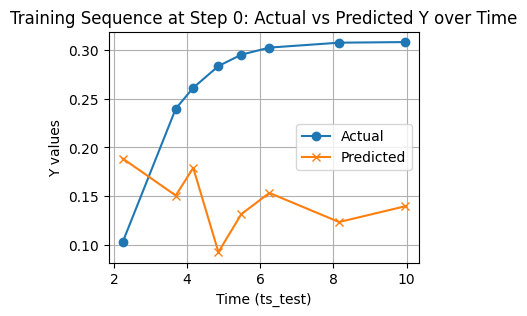

Step 100, Loss: 0.0006, Best Loss: 0.0005, Estimated Time Remaining: 515.22 minutes


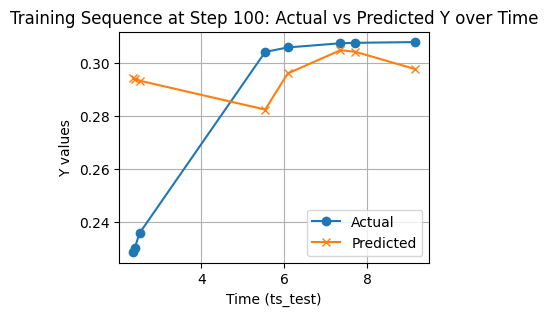

Step 200, Loss: 0.0005, Best Loss: 0.0005, Estimated Time Remaining: 48.59 minutes


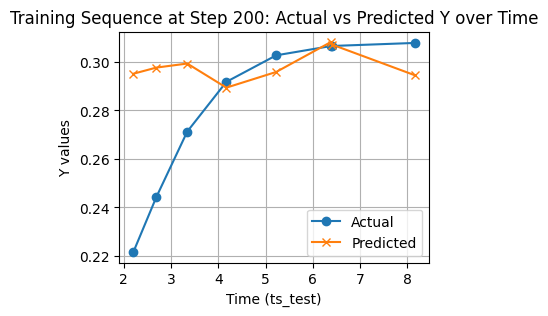

Step 300, Loss: 0.0005, Best Loss: 0.0005, Estimated Time Remaining: 43.07 minutes


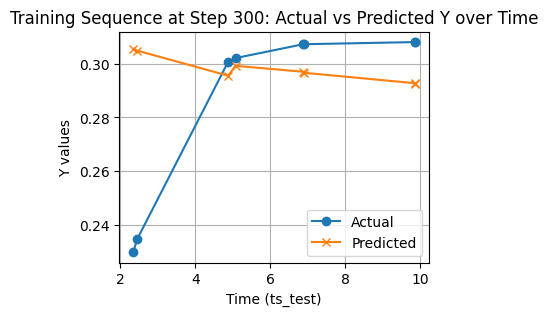

Step 400, Loss: 0.0005, Best Loss: 0.0005, Estimated Time Remaining: 38.70 minutes


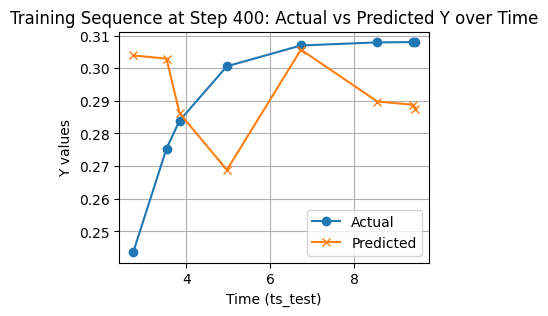

Step 500, Loss: 0.0005, Best Loss: 0.0005, Estimated Time Remaining: 35.91 minutes


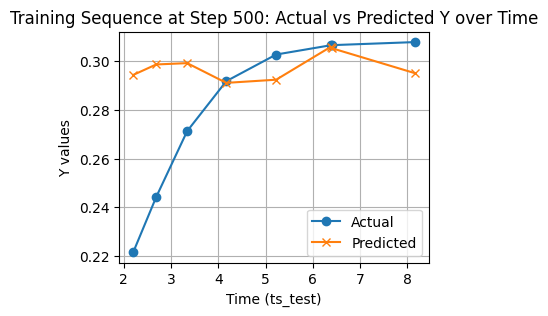

Step 600, Loss: 0.0005, Best Loss: 0.0005, Estimated Time Remaining: 33.13 minutes


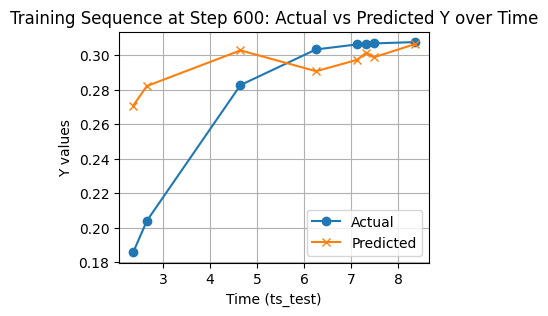

Step 700, Loss: 0.0005, Best Loss: 0.0005, Estimated Time Remaining: 30.86 minutes


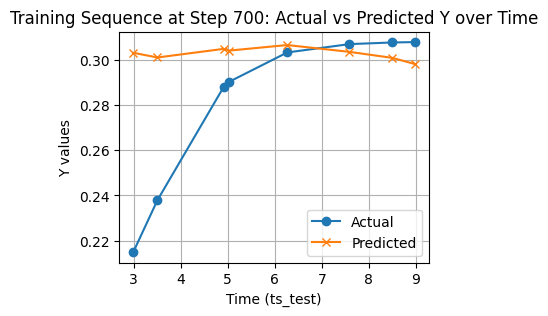

Step 800, Loss: 0.0005, Best Loss: 0.0005, Estimated Time Remaining: 28.81 minutes


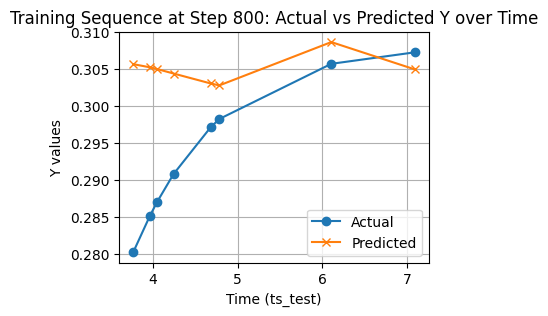

Step 900, Loss: 0.0005, Best Loss: 0.0005, Estimated Time Remaining: 25.69 minutes


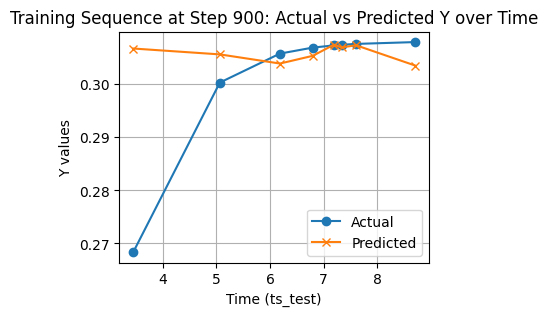

Step 1000, Loss: 0.0005, Best Loss: 0.0005, Estimated Time Remaining: 23.15 minutes


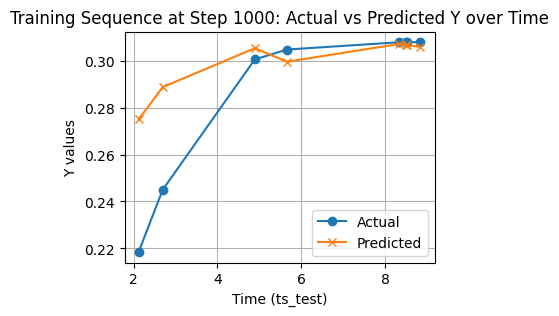

Step 1100, Loss: 0.0005, Best Loss: 0.0005, Estimated Time Remaining: 22.49 minutes


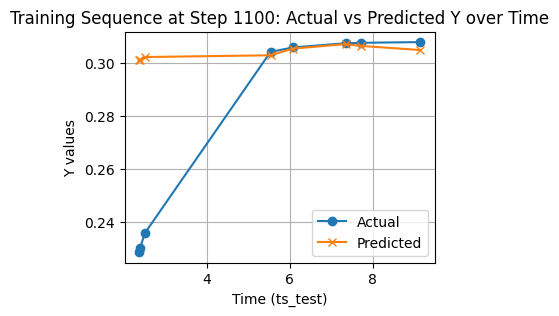

Step 1200, Loss: 0.0005, Best Loss: 0.0005, Estimated Time Remaining: 19.24 minutes


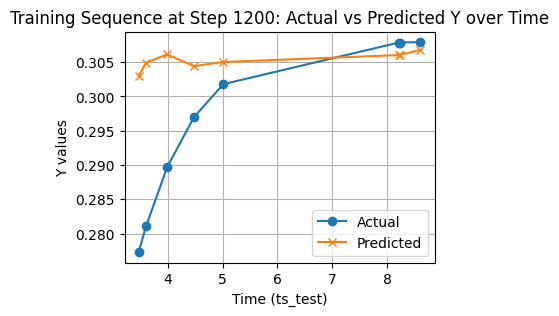

Stopping early at step 1202, no improvement for 200 steps.


In [30]:
batch_size = 32
train_steps = 2000
x_size = 3 
eta = 5e-3
num_train_seq = 512
train_seq_len = 32
train_test_ratio = 0.25 #note: This is the ratio of ys to (xs + ys) in the training set, not the train-test split ratio
func_mlp_width = 4
func_mlp_depth = 2
latent_size = 2
pred_mlp_width = 4
pred_mlp_depth = 2
num_test_seq = 5
test_seq_len = 200
test_test_ratio = 0.3
train_patience = 200
plot_every = 100

mlp = eqx.nn.MLP(in_size=latent_size, out_size=latent_size, width_size=func_mlp_width, depth=func_mlp_depth, key=key())  
func = Func(mlp=mlp) 

rnn_cell = eqx.nn.GRUCell(input_size=latent_size, hidden_size=latent_size, key=key())  
latent_to_y = eqx.nn.MLP(in_size=latent_size, out_size=1, width_size=pred_mlp_width, depth=pred_mlp_depth, key=key())

model = NeuralODEModel(func=func, rnn_cell=rnn_cell, latent_to_y=latent_to_y, latent_size=latent_size, x_size=x_size)

optimizer = optax.adam(learning_rate=eta)

train_data = get_data(num_sequences=num_train_seq, sequence_length=train_seq_len, test_ratio=train_test_ratio, key=key(), x_size = x_size)
trained_model = train(model, train_data, optimizer, steps=train_steps, batch_size=batch_size, seq_length=train_seq_len, eval_point_ratio = train_test_ratio, patience = train_patience, plot_every=plot_every)

In [31]:
test_data = get_data(num_sequences=num_test_seq, sequence_length=test_seq_len, test_ratio=test_test_ratio, key=key(),  x_size = x_size)

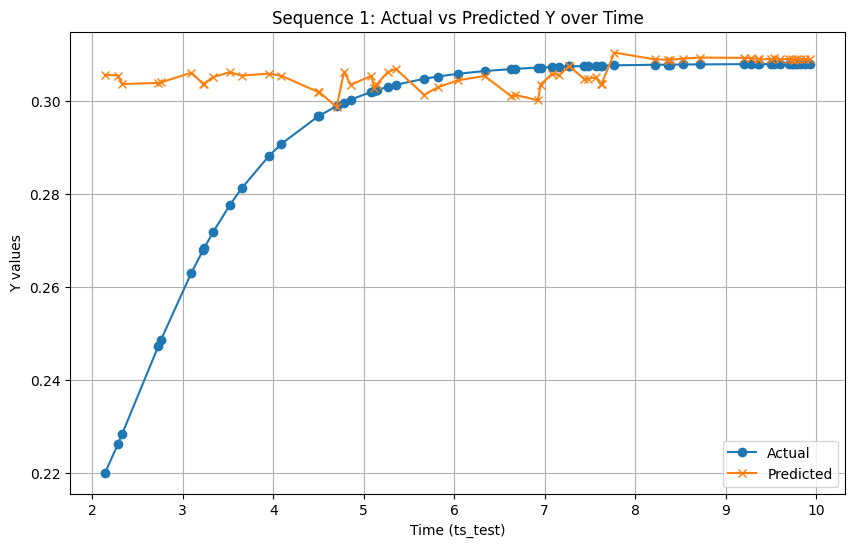

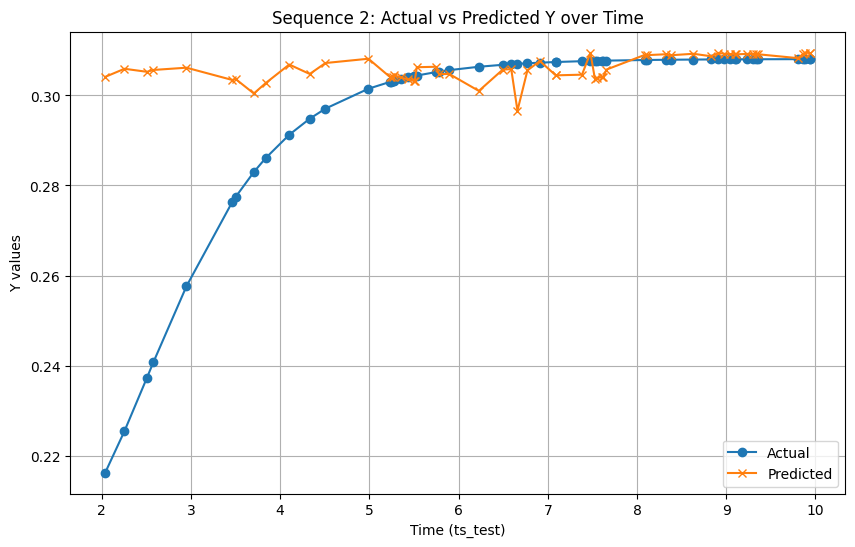

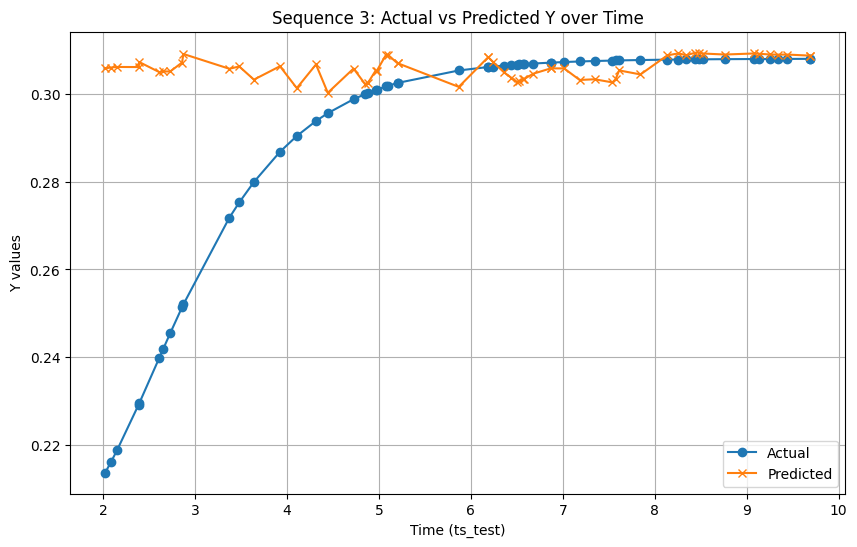

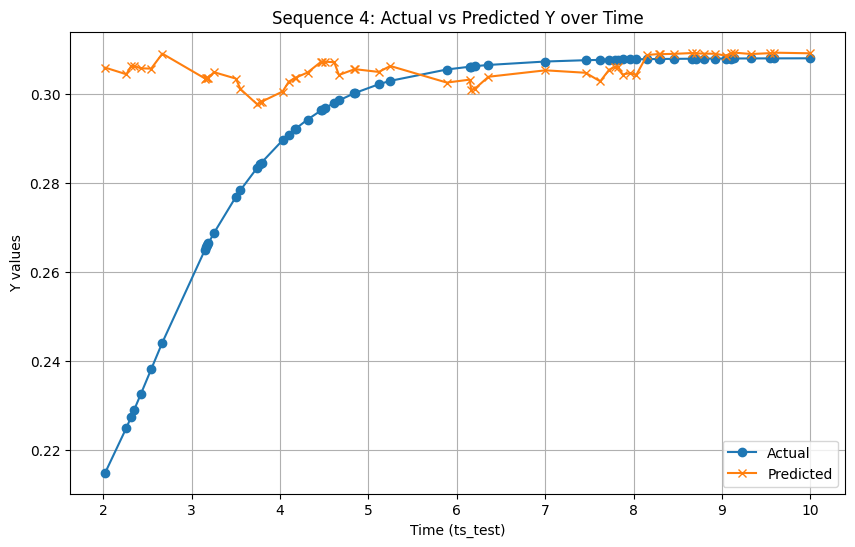

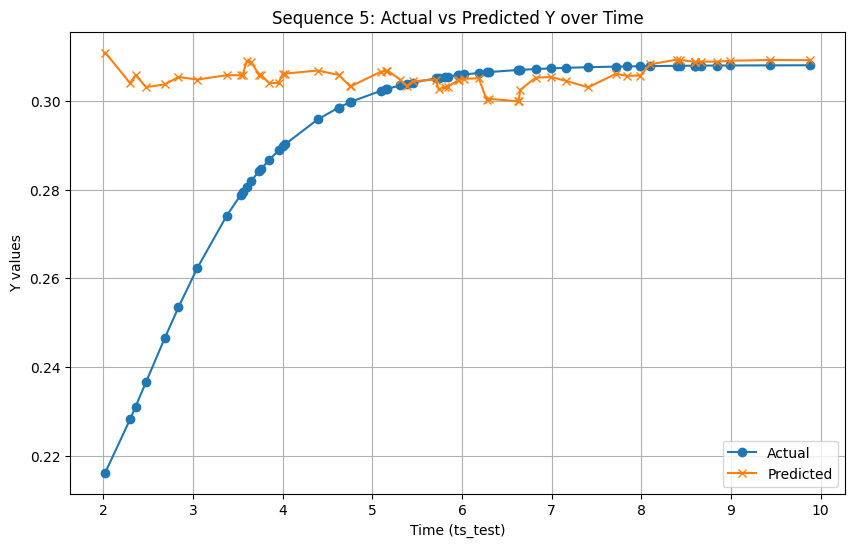

In [32]:
for idx in range(num_test_seq): 
    ts, xs, ts_test, y_true = test_data[idx]
    y_pred = trained_model.predict(jnp.expand_dims(ts, axis=0), jnp.expand_dims(xs, axis=0), jnp.expand_dims(ts_test, axis=0))
    y_pred = y_pred.squeeze()

    plt.figure(figsize=(10, 6))
    plt.plot(ts_test, y_true, label='Actual', marker='o')
    plt.plot(ts_test, y_pred, label='Predicted', marker='x')
    plt.xlabel('Time (ts_test)')
    plt.ylabel('Y values')
    plt.title(f'Sequence {idx + 1}: Actual vs Predicted Y over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

In [33]:
y_pred

Array([0.31088334, 0.30401134, 0.3058207 , 0.30311018, 0.3036959 ,
       0.30537796, 0.3048011 , 0.30577543, 0.30577636, 0.30581942,
       0.3089148 , 0.30876386, 0.30585077, 0.30588034, 0.30406797,
       0.30398434, 0.30608112, 0.306139  , 0.30683726, 0.30584216,
       0.3058434 , 0.3032696 , 0.3033428 , 0.30657682, 0.30677924,
       0.30681866, 0.30477995, 0.30331478, 0.3044272 , 0.3047999 ,
       0.3025881 , 0.3030753 , 0.3032084 , 0.30464667, 0.3046865 ,
       0.3049791 , 0.30508852, 0.30024147, 0.30047387, 0.29988325,
       0.2999174 , 0.30249208, 0.30524784, 0.30535722, 0.30449945,
       0.30305332, 0.30610633, 0.30563363, 0.30571342, 0.3082192 ,
       0.30930412, 0.30925578, 0.30878073, 0.30877933, 0.30877674,
       0.30886474, 0.30882245, 0.30904523, 0.30921325, 0.30917135],      dtype=float32)